In [1]:
# Run this cell
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

from time import time
import pandas as pd
import numpy as np

import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, Dense, Lambda

# import by me
from gensim.models import KeyedVectors
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, LSTM #, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from gensim import models

from matplotlib import pyplot as plt

from torchvision import transforms

from sklearn.metrics import precision_recall_fscore_support as score

from datetime import datetime

from scipy import spatial

from keras.layers import merge

from scipy.spatial.distance import cityblock

import cudf

Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


In [2]:
# import torch

torch.cuda.is_available()

device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [3]:
# Run this cell
class ModelParam(object):
    """
    define the parameters of the model
    """
    def __init__(
        self, 
        input_size1, # sentence length of language1
        input_size2, # sentence length of language2
        vocab_size, 
        sent_size, 
        embedding_dim,
        embedding_weights,
        #sent_vector,
    ):
        self.input_size1 = input_size1
        self.input_size2 = input_size2
        self.vocab_size = vocab_size
        self.sent_size = sent_size
        self.embedding_dim = embedding_dim
        self.embedding_weights = embedding_weights
        #self.sent_vector = sent_vector

In [4]:
# Run this cell
# initialize some variables
w2v_model = KeyedVectors.load_word2vec_format('vectors_embeddings.bin', binary=True)

# Inpute size
w2v_dim = 200

n_units_1st_layer = 64

# Training epoch number
n_epoch = 100

# Model Optimization parameters
batch_size = 64
gradient_clipping_norm = 1.25

# File name (or the intact file path) which indicates the model you want to save.
saved_model = "embeddings_saved_model.hdf5"

# Whether use early stopping
# If you turn off early stopping the auc values after each epoch will not be computed.
early_stopping_or_not = True

# Control parameters of early stopping
min_delta_value = 1e-3
patience_steps_num =50

In [5]:
# Run this cell

# TRAIN_CSV = 'train1.csv'
TRAIN_CSV = 'train_original.csv'
TEST_CSV = 'test.csv'

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

def text_to_word_list(text):
    
    text = str(text)
    text = text.upper()
    text = text.split()

    return text

In [6]:
# Run this cell

#test counters
wordFound = 0
wordNotFound = 0
# Prepare embedding
vocabulary = dict()
 # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
inverse_vocabulary = ['<unk>'] 

questions_cols = ['lang1', 'lang2']

# Iterate over the questions only of both training and test datasets
#For now Test dataset is a dummy small dataset with some instructions from training dataset
dataset = train_df
for index, row in dataset.iterrows():

    # Iterate through the text of both questions of the row
    for question in questions_cols:

        q2n = []  # q2n -> question numbers representation
        for word in text_to_word_list(row[question]):
            #print(word)
            # Check for unwanted words
            if word not in w2v_model.wv:
                print("Unknown word is found!!!")
                wordNotFound += 1
                continue


            if word not in vocabulary:
                vocabulary[word] = len(inverse_vocabulary)
                q2n.append(len(inverse_vocabulary))
                inverse_vocabulary.append(word)
            else:
                q2n.append(vocabulary[word])

            wordFound += 1
        # Replace questions as word to question as number representation
        dataset.at[index, question] = q2n
            
embedding_dim = w2v_dim
# This will be the embedding matrix
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  
embeddings[0] = 0  # So that the padding will be ignored

#print test counters
print("words found in model = ")
print(wordFound)
print("words NOT found in model")
print(wordNotFound)

VOCAB_SIZE = len(vocabulary)
print('vocab size ',VOCAB_SIZE)
# Building the embedding matrix
for word, index in vocabulary.items():
    #print('index ', index)
    if word in w2v_model.wv:
        #print(word)
        #print("above word found")
        embeddings[index] = w2v_model.wv[word]
        
print("This is the loaded embeddings")

print(embeddings)

# MOVQ~RBX,[RSP+0] LDR~R0,[R10+0]
# values = vocabulary.values()
# idx = values.index("MOVQ~RBX,[RSP+0]")
# print('idx = ',idx)
# vocabulary.get('LDR~R0,[R10+0]')

words found in model = 
1745024
words NOT found in model
0
vocab size  43254
This is the loaded embeddings
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.02004805e-02 -9.54385817e-01  4.67588007e-01 ...  2.22066343e-01
   6.05751812e-01 -8.38298917e-01]
 [-6.98797181e-02 -1.16516185e+00  2.76971191e-01 ...  6.78086698e-01
   4.69638079e-01 -5.87370574e-01]
 ...
 [-2.02880870e-03 -2.38929759e-03 -2.26852414e-03 ... -1.52107235e-03
  -1.53823849e-03  8.48464959e-04]
 [ 3.94527204e-02 -5.25413267e-02  2.50864401e-02 ... -1.61156747e-02
   1.87546294e-02 -1.14719808e-01]
 [ 1.00708006e-04  6.65512111e-04 -2.10678112e-03 ...  7.23190315e-04
   2.73895275e-04  1.80854800e-03]]


In [28]:
# Run this cell
# TRY WITH OUT REWRAPPING
# This is the model for generating predictions
# Takes parameters from ModelParam class

class crossLingualModel(nn.Module):
    def __init__(self, model_param: ModelParam):
        super().__init__()
        #Ifty
#         self.embedding = nn.Embedding(
#             model_param.vocab_size,
#             model_param.embedding_dim
#         )
        #self.embedding = embeddings
        #self.sent_vector = model_param.sent_vector
        
        # NEED TO CHECK PARAMETERS
        # Keras embedding
#         self.embedding = Embedding(model_param.vocab_size,
#                             model_param.embedding_dim,
#                             weights=[embeddings],
#                             #input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=True)
        # torch embedding
        ## No CHANGE in embedding for both random and pre trained vectors
        self.embedding = nn.Embedding(model_param.vocab_size,
                            model_param.embedding_dim)
#         weight = torch.FloatTensor(model_param.embedding_weights)
#         self.embedding = nn.Embedding.from_pretrained(weight, freeze=False)

#         self.embedding.weight.data.copy_(torch.from_numpy(model_param.embedding_weights))
        self.embedding.weight.data.copy_(model_param.embedding_weights)
    
        self.embedding.weight.requires_grad = True # for updating weights
        
        self.sent = torch.randn(
            model_param.sent_size, 
            requires_grad=True, 
            dtype=torch.float
        )
        
        self.linear = nn.Linear(
            model_param.embedding_dim + model_param.sent_size,
            model_param.vocab_size
        )
        
        self.softmax = nn.LogSoftmax(dim=1)
        
#         self.sigmoid = nn.Sigmoid()
        
        
        
    # x1: embeddings of context words in lang1
    # x2: embeddings of context words in lang2
    def forward(self, x1, x2, sent_vector):
        if(len(sent_vector) == 0 ):
            #Do Testing part
            #Now x1 and x2 are instructions in lang1 and lang2
            
            sent_vector_lang1 = text_to_word_list(x1)
            sent_vector_lang1 = [word for word in sent_vector_lang1 if word in w2v_model.wv]
            sent_vector_lang1_index_array = []
            for word in sent_vector_lang1:
                sent_vector_lang1_index_array.append(vocabulary.get(word))
#             sent_vector_lang1 = np.array(sent_vector_lang1_index_array)
            sent_vector_lang1 = sent_vector_lang1_index_array
            
            
            sent_vector_lang1 = torch.Tensor(sent_vector_lang1).to(device)
#             print('sent_vector_lang1 5', sent_vector_lang1)
            sent_vector_lang1 = sent_vector_lang1.to(torch.int)
#             print('sent_vector_lang1 6', sent_vector_lang1)
            
            sent_vector_lang1 = self.embedding(sent_vector_lang1)
            #print('embedding_output1 ',embedding_output1)
#             sent_vector_lang1 = sent_vector_lang1.numpy()
            if len(sent_vector_lang1) >= 1:
                sent_vector_lang1 = torch.stack([x.sum()/len(x) for x in sent_vector_lang1.transpose(0, -1)]) # .transpose(0, -1)
                
#                 sent_vector_lang1 = np.mean(sent_vector_lang1, axis=0)
            else:
                sent_vector_lang1 = torch.zeros(w2v_dim)
                
            sent_vector_lang2 = text_to_word_list(x2)
            sent_vector_lang2 = [word for word in sent_vector_lang2 if word in w2v_model.wv]
            sent_vector_lang2_index_array = []
            for word in sent_vector_lang2:
                sent_vector_lang2_index_array.append(vocabulary.get(word))
#             sent_vector_lang2 = np.array(sent_vector_lang2_index_array)
            sent_vector_lang2 = sent_vector_lang2_index_array
            
            
            sent_vector_lang2 = torch.Tensor(sent_vector_lang2).to(device)
#             print('sent_vector_lang2 5', sent_vector_lang2)
            sent_vector_lang2 = sent_vector_lang2.to(torch.int)
#             print('sent_vector_lang2 6', sent_vector_lang2)
            
            sent_vector_lang2 = self.embedding(sent_vector_lang2)
#             print('embedding_output sent_vector_lang2 ',sent_vector_lang2)
#             sent_vector_lang2 = sent_vector_lang2.numpy()
            if len(sent_vector_lang2) >= 1:
                sent_vector_lang2 = torch.stack([x.sum()/len(x) for x in sent_vector_lang2.transpose(0, -1)]) # .transpose(0, -1)
                
#                 sent_vector_lang2 = np.mean(sent_vector_lang2, axis=0)
            else:
                sent_vector_lang2 = torch.zeros(w2v_dim)
            
            #Not sure if these two lines should be added
#             print('sent_vector_lang1 size ', sent_vector_lang1.size())
#             sent_vector_lang1 = self.linear(sent_vector_lang1)
#             sent_vector_lang2 = self.linear(sent_vector_lang2)
            
            return [sent_vector_lang1, sent_vector_lang2]
        else:
            #Do prediction part
            #x1 = torch.FloatTensor(x1)
            #x2= torch.FloatTensor(x2)

            #modify part
            #NEED to get indices from words list in x1 and x2
            x1_index_array = []
            for word in x1:
                x1_index_array.append(vocabulary.get(word))

            x2_index_array = []
            for word in x2:
                x2_index_array.append(vocabulary.get(word))


#             x1 = np.array(x1_index_array) #, dtype=np.int32)
#             x2 = np.array(x2_index_array) #, dtype=np.int32)

            x1 = x1_index_array #, dtype=np.int32)
            x2 = x2_index_array #, dtype=np.int32)
            
            x1 = torch.Tensor(x1).to(device)
            x2 = torch.Tensor(x2).to(device)
            x1 = x1.to(torch.int)
            x2 = x2.to(torch.int)
            
            
    #         x1 = np.array((x1))
    #         x2 = np.array((x2))
            embedding_output1 = self.embedding(x1)
#             tmp = 3
#             if tmp in x1:
#             embeddings_layer_weights = self.embedding.get_weights()[0]
#             print('embeddings_layer_weights ',embeddings_layer_weights)

#             print('for x1 = ', x1)
#             print('embedding_output1',embedding_output1)
                
            # Write embedding o/p to file
#             f = open("output_of_small_train_set_after_ten_epoch.txt", "a")
#             f.write(str(x1))
#             f.write(str(embedding_output1))
#             f.close()
        
#             current_vec = self.embedding.weight
#             if prev_vec != current_vec:
#                 print('!=')
#             else:
#                 print('==')
#             prev_vec = current_vec
            
#             print("embedding weight ",self.embedding.weight)

#             embedding_output1 = torch.Tensor(embedding_output1.numpy())

    #         embedding_output1 = torch.FloatTensor(embedding_output1) #torch.Tensor(embedding_output1)
            embedding_output1 = F.relu(embedding_output1)
        
#             f = open("output_of_small_train_set_after_ten_epoch.txt", "a")
#             f.write(str(x1))
#             f.write(str(embedding_output1))
#             f.close()
#             print('embedding_output1 relu size = ',embedding_output1.size())
#             print('embedding_output1 relu = ',embedding_output1)
            
            
            
            embedding_output2 = self.embedding(x2)
#             embedding_output2 = torch.Tensor(embedding_output2.numpy())
            embedding_output2 = F.relu(embedding_output2)

            #working part
    #         embedding_output1 = x1 
    #         embedding_output1 = F.relu(embedding_output1)
    #         embedding_output2 = x2 
    #         embedding_output2 = F.relu(embedding_output2)



#             sum_embedding1 = torch.Tensor([x.sum() for x in embedding_output1.transpose(0, -1)])
#             sum_embedding2 = torch.Tensor([x.sum() for x in embedding_output2.transpose(0, -1)])
            
            sum_embedding1 = torch.stack([x.sum() for x in embedding_output1.transpose(0, -1)])
            sum_embedding2 = torch.stack([x.sum() for x in embedding_output2.transpose(0, -1)])
#             print('sum_embedding1 ',sum_embedding1)
            sent = self.sent

            # For modifying sent vector using embedding layer
#             print('sent_vector 1', sent_vector)
            sent_vector = text_to_word_list(sent_vector)
#             print('sent_vector 2', sent_vector)
            sent_vector = [word for word in sent_vector if word in w2v_model.wv]
#             print('sent_vector 3', sent_vector)
        
            sent_vector_index_array = []
            for word in sent_vector:
                sent_vector_index_array.append(vocabulary.get(word))
#             sent_vector = np.array(sent_vector_index_array)
            sent_vector = sent_vector_index_array
#             print('sent_vector 4', sent_vector)
            
            
            sent_vector = torch.Tensor(sent_vector).to(device)
#             print('sent_vector 5', sent_vector)
            
            sent_vector = sent_vector.to(torch.int)
#             print('sent_vector 6', sent_vector)
            
            
            sent_vector = self.embedding(sent_vector)
#             print('sent_vector 7', sent_vector)
            
            #print('embedding_output1 ',embedding_output1)
#             sent_vector = sent_vector.numpy()
#             if len(sent_vector) >= 1:
#             if tf.equal(tf.size(sent_vector), 0):
#                  sent_vector = torch.mean(sent_vector)
#             else:
#                 sent_vector = torch.zeros(w2v_dim)

#             sent_vector = torch.split(sent_vector, 1)
#             sent_vector = torch.mean(torch.stack(sent_vector))

#             mean = torch.mean(torch.stack(my_list))
#             sent_vector = torch.mean(sent_vector)

            # may need to change later
#             sent_vector = sent_vector.detach().numpy()
#             sent_vector = np.mean(sent_vector)
        
            # NEED TO FIND A WAY TO GET ELEMENT WISE AVERAGE OF TENSORS
#             sent_vector = torch.Tensor([x.sum()/len(x) for x in sent_vector.transpose(0, -1)]) # .transpose(0, -1)
            sent_vector = torch.stack([x.sum()/len(x) for x in sent_vector.transpose(0, -1)]) # .transpose(0, -1)
#             print('sent_vector ', sent_vector)
#             print('sent_vector 8', sent_vector)
    
#             print('sent_vector.size ',sent_vector.size())
#             print('sum_embedding1.size ',sum_embedding1.size())
            

#             concat1 = torch.cat((sum_embedding1, torch.Tensor(sent_vector)), 0)
#             concat2 = torch.cat((sum_embedding2, torch.Tensor(sent_vector)), 0)
            
            concat1 = torch.cat((sum_embedding1, sent_vector), 0)
            concat2 = torch.cat((sum_embedding2, sent_vector), 0)


    #         concat1 = torch.cat((sum_embedding1, torch.Tensor(sent_vector)), 0)
    #         concat2 = torch.cat((sum_embedding2, torch.Tensor(sent_vector)), 0)
    
#             print('concat1 size ', concat1.size())

            linear_output1 = self.linear(concat1)
            linear_output2 = self.linear(concat2)
            
#             print(self.linear.weight)



#             pred1 = self.softmax(linear_output1.reshape(1,-1))
#             pred2 = self.softmax(linear_output2.reshape(1,-1))
            
            
#             pred1 = self.sigmoid(linear_output1.reshape(1,-1))
#             pred2 = self.sigmoid(linear_output2.reshape(1,-1))
            
#             pred1 = pred1.narrow(1,0,200)
#             pred2 = pred2.narrow(1,0,200)
            

            # May need to sort
    #         print('pred1 size ', pred1.size())
    #         pred1 = torch.cat([pred1[0:200]]) #pred1[:200] #torch.reshape(pred1, (200, -1))
    #         pred2 = torch.cat([pred2[0:200]]) #pred2[:200] #torch.reshape(pred2, (200, -1))
#             print('after narrow pred1 size ', pred1.size())

            return [self.softmax(linear_output1.reshape(1,-1)).narrow(1,0,200), self.softmax(linear_output2.reshape(1,-1)).narrow(1,0,200)]
#             return [self.softmax(linear_output1.reshape(1,-1)), self.softmax(linear_output2.reshape(1,-1))]

In [8]:
# Run this cell
# For calculating word vector
def get_mean_vector(words):
    # remove out-of-vocabulary words #w2v_model.wv
    words = [word for word in words if word in w2v_model.wv]
    if len(words) >= 1:
        return np.mean(w2v_model.wv[words], axis=0)
    else:
        return np.zeros(w2v_dim) #[]

# Run this cell
# For getting center word and surrounding words according to sliding window with window size C
def get_windows(words_lang1, words_lang2, C):
    i = C
    #get word_list with min length
    lang1_len = len(words_lang1)
    lang2_len = len(words_lang2)
    min_len = min(lang1_len, lang2_len)
    
    while i < min_len - C:
        center_word_lang1 = words_lang1[i]
        center_word_lang2 = words_lang2[i]
        context_words_lang1 = words_lang1[(i - C):i] + words_lang1[(i+1):(i+C+1)]
        context_words_lang2 = words_lang2[(i - C):i] + words_lang2[(i+1):(i+C+1)]
        yield context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 
        i += 1
        
# Run this cell
def get_normalized_tensor(input_array):
    min_v = torch.min(input_array)
    range_v = torch.max(input_array) - min_v
    if range_v > 0:
        normalised = (input_array - min_v) / range_v
    else:
        normalised = torch.zeros(input_array.size())
    input_array = normalised
    return input_array

def get_normalized_array_from_array_using_tensor_formula(input_array):
    input_array = torch.from_numpy(input_array)
    input_array = torch.autograd.Variable(input_array)
    input_array = input_array.reshape(1,-1)
    
    return get_normalized_tensor(input_array).detach().numpy().flatten()

def process_words(words):
    result = ""
    for word in words:
#         if not word == words[-1]:
        result += word + " "
#         else:
#             result += word
    return result

In [20]:
# Prepare extended dataset
import csv

print('start time')
print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])

window_size = 2
# TRAIN_CSV = 'train1.csv'
# TRAIN_CSV = 'train_original.csv'
TRAIN_CSV = 'train_2.csv'


train_df = cudf.read_csv(TRAIN_CSV) #.to(device)

from sklearn.model_selection import train_test_split
train_X, test_X = train_test_split (train_df, test_size=0.2 )

dataset = train_X
for row in dataset.to_pandas().itertuples(): #iteritems(): #.to_pandas().iterrows():
    if (row.Index % 100) == 0:
        print('train dataset index', row.Index)


    for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row.lang1), text_to_word_list(row.lang2), window_size):
        
        #Write to a csv file
        with open('train_2_extended.csv', mode='a') as train_file:
            train_writer = csv.writer(train_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)

            train_writer.writerow([process_words(context_words_lang1), center_word_lang1, process_words(context_words_lang2), center_word_lang2, row.lang1+" "+row.lang2])
dataset = test_X
for row in dataset.to_pandas().itertuples(): #iteritems(): #.to_pandas().iterrows():
    if (row.Index % 100) == 0:
        print('val dataset index', row.Index)


    for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row.lang1), text_to_word_list(row.lang2), window_size):
        
        #Write to a csv file
        with open('train_validation_2_extended.csv', mode='a') as train_file:
            train_writer = csv.writer(train_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)

            train_writer.writerow([process_words(context_words_lang1), center_word_lang1, process_words(context_words_lang2), center_word_lang2, row.lang1+" "+row.lang2])
        
print('Done')   
print('end time')
print(datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])


start time
2021-07-06 07:20:20.085
train dataset index 500
train dataset index 200
train dataset index 0
train dataset index 400
train dataset index 300
train dataset index 100
Done
end time
2021-07-06 07:20:20.212


In [9]:
# MIT License
#
# Copyright (c) 2018 Stefano Nardo https://gist.github.com/stefanonardo
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        print('metrics ',metrics)
        if self.best is None:
            print('is None')
            self.best = metrics
            print('self.best = ',self.best)
            return False

#         if torch.isnan(metrics):
#             print('isnan')
#             return True

        if self.is_better(metrics, self.best):
            print('is_better')
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            print('not is_better')
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('>=')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [52]:
# Run this cell
# with nn.BCEWithLogitsLoss
# With changes for new model with embedding layer
# With SMALL dataset
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
epochs = 50
window_size = 2
# TRAIN_CSV = 'train1.csv'
# TRAIN_CSV = 'train_2.csv'
TRAIN_CSV = 'train_original.csv'

print_gap = 100
early_stopping_patience_value = 5

train_df = cudf.read_csv(TRAIN_CSV)

# 80% of total data in dataset is used for training and rest 20% will be used for testing
from sklearn.model_selection import train_test_split
train_X, test_X = train_test_split (train_df, test_size=0.2 )

questions_cols = ['lang1', 'lang2']
dataset = train_X
epoch_losses = list()
epoch_val_losses = list()

#keeping vocab size same as embedding dim
# VOCAB_SIZE = 200
# model_param = ModelParam(101, 101, VOCAB_SIZE + 1, 200, 200)

embeddings = torch.tensor(embeddings, dtype=torch.float, requires_grad=True)
# embeddings = get_normalized_tensor(embeddings)

model_param = ModelParam(101, 101, VOCAB_SIZE + 1, 200, 200, embeddings)

# model_param = ModelParam(101, 101, VOCAB_SIZE, 200, 200)

model = crossLingualModel(model_param).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimal for weight_decay=1e-4
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# print('model parameters grad ', list(model.parameters())[0].grad)
# for p in model.parameters():
#     if p.grad is not None:
#         print('grad is not None')
#         print(p.grad.data)
#     else:
#         print('p.grad is None')

batch_size = 32
number_of_predictions = 0


now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
if_to_store_center_word = False #True
# metric = 100

es = EarlyStopping(patience=early_stopping_patience_value)

for epoch in range(epochs):
    #number_of_predictions = 0
#     if(epoch == 99):
#         if_to_store_center_word = True
    print('at epoch', epoch)
    print('model parameters grad 0', list(model.parameters())[0].grad)
    print('model parameters grad 1', list(model.parameters())[1].grad)
    print('model parameters grad 2', list(model.parameters())[2].grad)
    dataset = train_X
    intermediate_losses = list()
#     for index, row in dataset.iterrows():
    for row in dataset.to_pandas().itertuples():
        if (row.Index % print_gap) == 0:
            print('training index ', row.Index)
        #print('train dataset index', index)
        #calculate paragraph vector for entire row
#         sent_vector = get_mean_vector(text_to_word_list(row))
        sent_vector = row #text_to_word_list(row)
        
        #print(sent_vector)
     
        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row.lang1), text_to_word_list(row.lang2), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []


            optimizer.zero_grad()
            model.zero_grad()
            prediction1, prediction2 = model(context_words_lang1, context_words_lang2, sent_vector)

            
            number_of_predictions += 1
            #print(prediction1)
            
            #embedding for target word in lang1
            target1 = w2v_model.wv[center_word_lang1]
#             target1 = np.resize(target1,(1,VOCAB_SIZE + 1))

   
            
            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)
            
            #for normalizing single tensor
            
            target1 = get_normalized_tensor(target1).to(device)

            
            prediction1 = get_normalized_tensor(prediction1)

    
            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
#             loss_lang1 = nn.MSELoss()(prediction1, target1)
        
           
            #embedding for target word in lang2
            target2 = w2v_model.wv[center_word_lang2]
#             target2 = np.resize(target2,(1,VOCAB_SIZE + 1))

            
            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)
            
            # Was for normalizing single tensor
            target2 = get_normalized_tensor(target2).to(device)
            
#             prediction2 = prediction2/predNorm2
            
            # for normalizing single tensor
            prediction2 = get_normalized_tensor(prediction2)
            
            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)
#             loss_lang2 = nn.MSELoss()(prediction2, target2)
            

            summed_loss = loss_lang1 + loss_lang2 
            intermediate_losses.append(summed_loss.item())
            
            if(number_of_predictions % batch_size == 0):
#                 model.zero_grad()

                a = list(model.parameters())[1].clone()
#                 loss_lang1.backward()
#                 loss_lang2.backward()
    
                summed_loss.backward()
                optimizer.step()
                
                b = list(model.parameters())[1].clone()
#                 print('if torch.equal(a.data, b.data)', torch.equal(a.data, b.data))
            
                number_of_predictions = 0
                #print('updated model params')

    
    epoch_losses.append(np.mean(intermediate_losses))
    
    # Validation
    with torch.no_grad():
        dataset = test_X
        intermediate_val_losses = list()
#         for index, row in dataset.iterrows():
        for row in dataset.to_pandas().itertuples():
            if (row.Index % print_gap) == 0:
                print('validation index ', row.Index)
            #print('validation dataset index', index)
            #calculate paragraph vector for entire row
            sent_vector = row #text_to_word_list(row)
            #print(sent_vector)


            for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row.lang1), text_to_word_list(row.lang2), window_size):
                context_words_lang1_array = []
                context_words_lang2_array = []
                
                prediction1, prediction2 = model(context_words_lang1, context_words_lang2, sent_vector)


                #embedding for target word in lang1
                target1 = w2v_model.wv[center_word_lang1]
#                 target1 = np.resize(target1,(1,VOCAB_SIZE + 1))

                target1 = torch.from_numpy(target1)
                target1 = torch.autograd.Variable(target1)
                target1 = target1.reshape(1,-1)

                target1 = get_normalized_tensor(target1).to(device)
                prediction1 = get_normalized_tensor(prediction1)

                loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)

                #embedding for target word in lang2
                target2 = w2v_model.wv[center_word_lang2]
#                 target2 = np.resize(target2,(1,VOCAB_SIZE + 1))


                target2 = torch.from_numpy(target2)
                target2 = torch.autograd.Variable(target2)
                target2 = target2.reshape(1,-1)
                
                target2 = get_normalized_tensor(target2).to(device)
                prediction2 = get_normalized_tensor(prediction2)

                loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)

                summed_loss = loss_lang1 + loss_lang2  
                
                
                intermediate_val_losses.append(summed_loss.item())

        epoch_val_losses.append(np.mean(intermediate_val_losses))
        
        metric = np.mean(intermediate_val_losses)
#         print('metric ',metric)
#         #metric = metric - 3
        if es.step(metric):
            print('early stopping at epoch ',epoch)
            break  # early stop criterion is met, we can stop now
    
    torch.save(model, "saved_model.pth")
        
print('epoch_losses ',epoch_losses)
print(' ')
print('epoch_val_losses ',epoch_val_losses)

# print('after 10 epochs')
# print(embeddings)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

# model = torch.load(saved_model.pth)
# model.eval()

<ipython-input-52-eda45fe919cd>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(embeddings, dtype=torch.float, requires_grad=True)


Start Time = 01:11:25
at epoch 0
model parameters grad 0 None
model parameters grad 1 None
model parameters grad 2 None
training index  36700
training index  58400
training index  62600
training index  5900
training index  1700
training index  10600
training index  66200
training index  46200
training index  70500
training index  92500
training index  63500
training index  19500
training index  68000
training index  68700
training index  58100
training index  92800
training index  79100
training index  86500
training index  88900
training index  67400
training index  69300
training index  14100
training index  79000
training index  66500
training index  84600
training index  1000
training index  79500
training index  22700
training index  20600
training index  27200
training index  51400
training index  29900
training index  34200
training index  73700
training index  1300
training index  68400
training index  61700
training index  86000
training index  26400
training index  80000
trai

training index  56900
training index  43300
training index  56200
training index  26500
training index  72900
training index  6600
training index  78900
training index  18700
training index  2300
training index  87400
training index  16900
training index  70700
training index  88000
training index  63300
training index  41100
training index  10700
training index  44900
training index  43500
training index  93300
training index  62100
training index  68900
training index  91400
training index  92400
training index  65500
training index  11800
training index  1900
training index  66400
training index  74800
training index  16000
training index  23300
training index  18600
training index  42300
training index  24100
training index  44700
training index  31700
training index  40200
training index  43100
training index  37400
training index  22100
training index  60400
training index  42700
training index  30600
training index  66100
training index  9800
training index  67600
training index

validation index  56400
validation index  34300
validation index  32800
validation index  28900
validation index  34700
validation index  64000
validation index  71300
validation index  38400
validation index  39300
validation index  21100
validation index  83200
validation index  41600
validation index  34500
validation index  57400
validation index  5800
validation index  77900
validation index  25400
validation index  82100
validation index  34600
validation index  42600
validation index  22600
validation index  69700
validation index  35600
validation index  15800
validation index  22500
validation index  25200
validation index  74400
validation index  27300
validation index  33200
validation index  24400
validation index  14300
validation index  62000
validation index  79900
validation index  12300
validation index  90100
validation index  55800
validation index  91200
validation index  65100
validation index  2100
validation index  92100
validation index  23700
validation index  

training index  47400
training index  65900
training index  12800
training index  0
training index  66700
training index  76100
training index  19700
training index  57200
training index  15900
training index  59900
training index  46500
training index  37100
training index  46900
training index  32000
training index  51000
training index  72200
training index  61900
training index  61000
training index  55900
training index  400
training index  65200
training index  35300
training index  28700
training index  12700
training index  81000
training index  28100
training index  1100
training index  90000
training index  63700
training index  72800
training index  67900
training index  6000
training index  15500
training index  89000
training index  2800
training index  33600
training index  84900
training index  35700
training index  16700
training index  74100
training index  10500
training index  45200
training index  52000
training index  20700
training index  29600
training index  399

training index  60300
training index  72000
training index  70600
training index  40500
training index  24200
training index  6900
training index  78700
training index  80500
training index  47600
training index  12200
training index  34800
training index  71200
training index  84800
training index  51600
training index  52800
training index  7000
training index  87700
training index  32700
training index  54900
training index  62500
training index  11200
training index  8200
training index  30900
training index  17900
training index  48800
training index  54600
training index  11600
training index  14400
training index  85900
training index  49000
training index  35800
training index  86600
training index  69000
training index  32900
training index  1600
training index  76400
training index  15300
training index  86900
training index  25900
training index  77700
training index  1500
training index  81200
training index  59300
training index  14000
training index  6500
training index  

validation index  1800
validation index  85700
validation index  84000
validation index  4400
validation index  45100
validation index  91100
validation index  5700
validation index  89600
validation index  59400
validation index  18000
validation index  87000
validation index  66600
validation index  4800
validation index  16600
validation index  83300
validation index  92700
validation index  23400
validation index  48300
validation index  92200
validation index  19200
validation index  31600
validation index  52400
validation index  5400
validation index  53900
validation index  58300
validation index  81400
validation index  83400
validation index  74500
validation index  60600
validation index  24300
validation index  78600
validation index  29200
validation index  14900
validation index  75400
validation index  90700
validation index  27800
validation index  28500
validation index  55600
validation index  51900
validation index  48700
validation index  73200
validation index  412

training index  82600
training index  85400
training index  74700
training index  18200
training index  59600
training index  63900
training index  73800
training index  31300
training index  71100
training index  81800
training index  4900
training index  63400
training index  55300
training index  62900
training index  26300
training index  9600
training index  40700
training index  41700
training index  53100
training index  74600
training index  50900
training index  88600
training index  20400
training index  66800
training index  73500
training index  28400
training index  80900
training index  27400
training index  37900
training index  45800
training index  59100
training index  8500
training index  30000
training index  38100
training index  71400
training index  29500
training index  36300
training index  21400
training index  39200
training index  70200
training index  46700
training index  41900
training index  12100
training index  88500
training index  76200
training inde

training index  66900
training index  48900
training index  69400
training index  48100
training index  23800
training index  86200
training index  89400
training index  76700
training index  89100
training index  4700
training index  73400
training index  15600
training index  56300
training index  28000
training index  500
training index  60800
training index  29300
training index  44100
training index  36400
training index  49300
training index  14800
training index  85500
training index  49700
training index  88800
training index  63000
training index  36200
training index  15200
training index  61100
training index  63800
training index  44800
training index  33500
training index  84100
training index  47800
training index  17700
training index  32200
training index  4000
training index  90600
training index  69200
training index  49500
training index  16100
training index  22200
training index  80800
training index  57000
training index  35000
training index  9300
training index 

training index  80000
training index  50300
training index  83600
training index  81500
training index  1200
training index  88400
training index  10000
training index  29000
training index  72700
training index  64600
training index  76500
training index  26600
training index  3200
training index  58600
training index  56000
training index  43700
training index  78200
training index  64200
training index  5200
training index  26800
training index  92600
training index  90900
training index  6100
training index  79300
training index  19300
training index  78300
training index  24000
training index  44000
training index  43600
training index  36600
training index  38500
training index  23500
training index  44500
training index  87500
training index  42900
training index  82900
training index  2000
training index  21600
training index  4600
training index  71600
training index  1400
training index  2400
training index  12900
training index  13600
training index  58200
training index  17

training index  67600
training index  89700
training index  6800
training index  47200
training index  89200
training index  59000
training index  19000
training index  23600
training index  68300
training index  59700
training index  20100
training index  59500
training index  61800
training index  18900
training index  3700
training index  56600
training index  24900
training index  16800
training index  3400
training index  37800
training index  78400
training index  91700
training index  13400
training index  16200
training index  43000
training index  15700
training index  78800
training index  11000
training index  49800
training index  61400
training index  53800
training index  24600
training index  89900
training index  9700
training index  89800
training index  72100
training index  51300
training index  52900
training index  10200
training index  88200
training index  33900
training index  20800
training index  7600
training index  52500
training index  34100
training index 

validation index  89500
validation index  800
validation index  29700
validation index  16400
validation index  9500
validation index  93200
validation index  5100
validation index  51100
validation index  27000
validation index  15100
validation index  18100
validation index  82000
validation index  11900
validation index  77800
validation index  20000
validation index  46800
validation index  81300
validation index  43900
validation index  57300
validation index  34900
validation index  30700
validation index  8100
validation index  7900
validation index  71900
validation index  57600
validation index  16300
validation index  8300
validation index  55400
validation index  44300
validation index  71500
validation index  77500
validation index  91500
validation index  19400
validation index  39100
validation index  57900
validation index  70800
validation index  80300
validation index  19100
validation index  33800
validation index  7400
validation index  26000
validation index  48400


training index  42400
training index  84200
training index  53400
training index  31400
training index  90300
training index  10800
training index  14700
training index  5500
training index  38700
training index  65400
training index  8400
training index  81100
training index  87600
training index  7800
training index  47300
training index  64700
training index  55700
training index  69900
training index  14500
training index  73600
training index  36900
training index  9000
training index  53600
training index  25800
training index  61200
training index  70900
training index  10400
training index  79400
training index  7300
training index  90400
training index  71700
training index  42100
training index  65000
training index  61300
training index  74200
training index  43400
training index  60500
training index  46400
training index  23200
training index  72400
training index  54100
training index  75000
training index  87100
training index  30800
training index  79800
training index 

training index  48500
training index  6200
training index  79700
training index  53700
training index  27600
training index  21800
training index  83100
training index  21300
training index  19900
training index  27700
training index  12400
training index  75900
training index  41800
training index  70100
training index  64400
training index  12000
training index  23100
training index  48600
training index  59800
training index  8900
training index  8000
training index  17300
training index  47900
training index  80100
training index  58800
training index  22900
training index  18500
training index  28800
training index  7700
training index  66000
training index  10300
training index  87800
training index  65300
training index  48200
training index  72600
training index  15400
training index  85200
training index  44600
training index  45600
training index  39700
training index  37500
training index  22000
training index  68500
training index  75700
training index  73900
training index

validation index  67500
validation index  47000
validation index  49900
validation index  62200
validation index  62700
validation index  61500
validation index  17200
validation index  86400
validation index  71800
validation index  38300
validation index  28300
validation index  36800
validation index  43800
validation index  29800
validation index  60000
validation index  91300
validation index  3000
validation index  42800
validation index  83700
validation index  78000
metrics  1.3552372176534124
not is_better
at epoch 5
model parameters grad 0 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
model parameters grad 1 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0.,

training index  67100
training index  200
training index  65700
training index  60900
training index  3600
training index  47100
training index  3500
training index  50500
training index  21700
training index  35200
training index  52700
training index  75600
training index  45700
training index  20200
training index  87200
training index  9900
training index  27500
training index  62400
training index  59200
training index  41300
training index  42200
training index  84300
training index  72300
training index  300
training index  68800
training index  21900
training index  18800
training index  35900
training index  38600
training index  55500
training index  4100
training index  26900
training index  49600
training index  80600
training index  5300
training index  7500
training index  73300
training index  25600
training index  51700
training index  73100
training index  76600
training index  62800
training index  84700
training index  5000
training index  56700
training index  30200

training index  30400
training index  11700
training index  31200
training index  86100
training index  82500
training index  26700
training index  33300
training index  75200
training index  48000
training index  31900
training index  27900
training index  50800
training index  3100
training index  28200
training index  86700
training index  11100
training index  57800
training index  44400
training index  76800
training index  82400
training index  46000
training index  70000
training index  83800
training index  54700
training index  41000
training index  32300
training index  29400
training index  12500
training index  50600
training index  40400
training index  40000
training index  9400
training index  92900
training index  31000
training index  10100
training index  43200
training index  93000
training index  85000
training index  72500
training index  91800
training index  67300
training index  75800
training index  24800
training index  38900
training index  53300
training ind

training index  25000
training index  77000
training index  8800
training index  10900
training index  93100
training index  54400
training index  18300
training index  86800
training index  13000
training index  56800
training index  31800
training index  52600
training index  49100
training index  13800
training index  2900
training index  33000
training index  22800
training index  83500
training index  74000
training index  31100
training index  68100
training index  92000
training index  69800
training index  2200
training index  14200
training index  2500
training index  53200
training index  52300
training index  75500
training index  22300
training index  54800
training index  79600
training index  54300
training index  21000
training index  91600
training index  40300
training index  900
training index  69500
training index  7200
training index  80400
training index  30100
training index  8600
training index  32100
training index  45900
training index  68200
training index  76

training index  70400
training index  46100
training index  79200
training index  67200
training index  50000
training index  6400
training index  33700
training index  47500
training index  22400
training index  63600
training index  85600
training index  11300
training index  42000
training index  41500
training index  91900
training index  25700
training index  700
training index  6300
training index  14600
training index  30500
training index  50100
training index  68600
training index  11400
training index  62300
training index  17800
training index  81600
training index  20500
training index  17600
training index  75100
training index  50700
training index  51800
training index  20300
training index  80200
training index  90500
training index  70300
training index  76300
training index  38200
training index  77600
training index  25300
training index  47700
training index  39000
training index  37200
training index  11500
training index  74300
training index  84500
training index

validation index  90800
validation index  81700
validation index  92300
validation index  26100
validation index  39500
validation index  3300
validation index  100
validation index  19600
validation index  38000
validation index  52100
validation index  77400
validation index  600
validation index  33100
validation index  58000
validation index  32400
validation index  50400
validation index  56500
validation index  39600
validation index  63200
validation index  27100
validation index  91000
validation index  32600
validation index  4200
validation index  55100
validation index  8700
validation index  42500
validation index  45400
validation index  88300
validation index  55000
validation index  7100
validation index  37000
validation index  9200
validation index  13700
validation index  64300
validation index  4500
validation index  21500
validation index  58900
validation index  13200
validation index  4300
validation index  46300
validation index  69600
validation index  50200
val

training index  53500
training index  40900
training index  32500
training index  65600
training index  40600
training index  21200
training index  37700
training index  30300
training index  67000
training index  78500
training index  54200
training index  38800
training index  12600
training index  64100
training index  36500
training index  76000
training index  16500
training index  25100
training index  53000
training index  58700
training index  49200
training index  2700
training index  37600
training index  17400
training index  66300
training index  82200
training index  85800
training index  60100
training index  41400
training index  6700
training index  29100
training index  46600
training index  67700
training index  57500
training index  74900
training index  77300
training index  69100
training index  35100
training index  60200
training index  28600
training index  64800
training index  18400
training index  19800
training index  39400
training index  13500
training ind

training index  26200
training index  80700
training index  60700
training index  36000
training index  39800
training index  89300
training index  23900
training index  57700
training index  51200
training index  25500
training index  17100
training index  13900
training index  64500
training index  73000
training index  9100
training index  87300
training index  52200
training index  45000
training index  37300
training index  87900
training index  35500
training index  3900
training index  17500
training index  84400
training index  34400
training index  13100
training index  86300
training index  65800
training index  77100
training index  45300
training index  55200
training index  24500
training index  78100
training index  85100
training index  49400
training index  64900
training index  88700
training index  13300
training index  40800
training index  3800
training index  61600
training index  57100
training index  15000
training index  44200
training index  2600
training index

training index  36700
training index  58400
training index  62600
training index  5900
training index  1700
training index  10600
training index  66200
training index  46200
training index  70500
training index  92500
training index  63500
training index  19500
training index  68000
training index  68700
training index  58100
training index  92800
training index  79100
training index  86500
training index  88900
training index  67400
training index  69300
training index  14100
training index  79000
training index  66500
training index  84600
training index  1000
training index  79500
training index  22700
training index  20600
training index  27200
training index  51400
training index  29900
training index  34200
training index  73700
training index  1300
training index  68400
training index  61700
training index  86000
training index  26400
training index  80000
training index  50300
training index  83600
training index  81500
training index  1200
training index  88400
training index 

training index  6600
training index  78900
training index  18700
training index  2300
training index  87400
training index  16900
training index  70700
training index  88000
training index  63300
training index  41100
training index  10700
training index  44900
training index  43500
training index  93300
training index  62100
training index  68900
training index  91400
training index  92400
training index  65500
training index  11800
training index  1900
training index  66400
training index  74800
training index  16000
training index  23300
training index  18600
training index  42300
training index  24100
training index  44700
training index  31700
training index  40200
training index  43100
training index  37400
training index  22100
training index  60400
training index  42700
training index  30600
training index  66100
training index  9800
training index  67600
training index  89700
training index  6800
training index  47200
training index  89200
training index  59000
training index 

validation index  64000
validation index  71300
validation index  38400
validation index  39300
validation index  21100
validation index  83200
validation index  41600
validation index  34500
validation index  57400
validation index  5800
validation index  77900
validation index  25400
validation index  82100
validation index  34600
validation index  42600
validation index  22600
validation index  69700
validation index  35600
validation index  15800
validation index  22500
validation index  25200
validation index  74400
validation index  27300
validation index  33200
validation index  24400
validation index  14300
validation index  62000
validation index  79900
validation index  12300
validation index  90100
validation index  55800
validation index  91200
validation index  65100
validation index  2100
validation index  92100
validation index  23700
validation index  89500
validation index  800
validation index  29700
validation index  16400
validation index  9500
validation index  932

training index  15900
training index  59900
training index  46500
training index  37100
training index  46900
training index  32000
training index  51000
training index  72200
training index  61900
training index  61000
training index  55900
training index  400
training index  65200
training index  35300
training index  28700
training index  12700
training index  81000
training index  28100
training index  1100
training index  90000
training index  63700
training index  72800
training index  67900
training index  6000
training index  15500
training index  89000
training index  2800
training index  33600
training index  84900
training index  35700
training index  16700
training index  74100
training index  10500
training index  45200
training index  52000
training index  20700
training index  29600
training index  39900
training index  42400
training index  84200
training index  53400
training index  31400
training index  90300
training index  10800
training index  14700
training index 

training index  47600
training index  12200
training index  34800
training index  71200
training index  84800
training index  51600
training index  52800
training index  7000
training index  87700
training index  32700
training index  54900
training index  62500
training index  11200
training index  8200
training index  30900
training index  17900
training index  48800
training index  54600
training index  11600
training index  14400
training index  85900
training index  49000
training index  35800
training index  86600
training index  69000
training index  32900
training index  1600
training index  76400
training index  15300
training index  86900
training index  25900
training index  77700
training index  1500
training index  81200
training index  59300
training index  14000
training index  6500
training index  63100
training index  48500
training index  6200
training index  79700
training index  53700
training index  27600
training index  21800
training index  83100
training index  

validation index  89600
validation index  59400
validation index  18000
validation index  87000
validation index  66600
validation index  4800
validation index  16600
validation index  83300
validation index  92700
validation index  23400
validation index  48300
validation index  92200
validation index  19200
validation index  31600
validation index  52400
validation index  5400
validation index  53900
validation index  58300
validation index  81400
validation index  83400
validation index  74500
validation index  60600
validation index  24300
validation index  78600
validation index  29200
validation index  14900
validation index  75400
validation index  90700
validation index  27800
validation index  28500
validation index  55600
validation index  51900
validation index  48700
validation index  73200
validation index  41200
validation index  67500
validation index  47000
validation index  49900
validation index  62200
validation index  62700
validation index  61500
validation index  

training index  71100
training index  81800
training index  4900
training index  63400
training index  55300
training index  62900
training index  26300
training index  9600
training index  40700
training index  41700
training index  53100
training index  74600
training index  50900
training index  88600
training index  20400
training index  66800
training index  73500
training index  28400
training index  80900
training index  27400
training index  37900
training index  45800
training index  59100
training index  8500
training index  30000
training index  38100
training index  71400
training index  29500
training index  36300
training index  21400
training index  39200
training index  70200
training index  46700
training index  41900
training index  12100
training index  88500
training index  76200
training index  54000
training index  67100
training index  200
training index  65700
training index  60900
training index  3600
training index  47100
training index  3500
training index  5

training index  89100
training index  4700
training index  73400
training index  15600
training index  56300
training index  28000
training index  500
training index  60800
training index  29300
training index  44100
training index  36400
training index  49300
training index  14800
training index  85500
training index  49700
training index  88800
training index  63000
training index  36200
training index  15200
training index  61100
training index  63800
training index  44800
training index  33500
training index  84100
training index  47800
training index  17700
training index  32200
training index  4000
training index  90600
training index  69200
training index  49500
training index  16100
training index  22200
training index  80800
training index  57000
training index  35000
training index  9300
training index  31500
training index  30400
training index  11700
training index  31200
training index  86100
training index  82500
training index  26700
training index  33300
training index 

training index  72700
training index  64600
training index  76500
training index  26600
training index  3200
training index  58600
training index  56000
training index  43700
training index  78200
training index  64200
training index  5200
training index  26800
training index  92600
training index  90900
training index  6100
training index  79300
training index  19300
training index  78300
training index  24000
training index  44000
training index  43600
training index  36600
training index  38500
training index  23500
training index  44500
training index  87500
training index  42900
training index  82900
training index  2000
training index  21600
training index  4600
training index  71600
training index  1400
training index  2400
training index  12900
training index  13600
training index  58200
training index  17000
training index  25000
training index  77000
training index  8800
training index  10900
training index  93100
training index  54400
training index  18300
training index  86

training index  68300
training index  59700
training index  20100
training index  59500
training index  61800
training index  18900
training index  3700
training index  56600
training index  24900
training index  16800
training index  3400
training index  37800
training index  78400
training index  91700
training index  13400
training index  16200
training index  43000
training index  15700
training index  78800
training index  11000
training index  49800
training index  61400
training index  53800
training index  24600
training index  89900
training index  9700
training index  89800
training index  72100
training index  51300
training index  52900
training index  10200
training index  88200
training index  33900
training index  20800
training index  7600
training index  52500
training index  34100
training index  56100
training index  70400
training index  46100
training index  79200
training index  67200
training index  50000
training index  6400
training index  33700
training index 

validation index  51100
validation index  27000
validation index  15100
validation index  18100
validation index  82000
validation index  11900
validation index  77800
validation index  20000
validation index  46800
validation index  81300
validation index  43900
validation index  57300
validation index  34900
validation index  30700
validation index  8100
validation index  7900
validation index  71900
validation index  57600
validation index  16300
validation index  8300
validation index  55400
validation index  44300
validation index  71500
validation index  77500
validation index  91500
validation index  19400
validation index  39100
validation index  57900
validation index  70800
validation index  80300
validation index  19100
validation index  33800
validation index  7400
validation index  26000
validation index  48400
validation index  90800
validation index  81700
validation index  92300
validation index  26100
validation index  39500
validation index  3300
validation index  100

training index  5500
training index  38700
training index  65400
training index  8400
training index  81100
training index  87600
training index  7800
training index  47300
training index  64700
training index  55700
training index  69900
training index  14500
training index  73600
training index  36900
training index  9000
training index  53600
training index  25800
training index  61200
training index  70900
training index  10400
training index  79400
training index  7300
training index  90400
training index  71700
training index  42100
training index  65000
training index  61300
training index  74200
training index  43400
training index  60500
training index  46400
training index  23200
training index  72400
training index  54100
training index  75000
training index  87100
training index  30800
training index  79800
training index  85300
training index  53500
training index  40900
training index  32500
training index  65600
training index  40600
training index  21200
training index 

training index  21300
training index  19900
training index  27700
training index  12400
training index  75900
training index  41800
training index  70100
training index  64400
training index  12000
training index  23100
training index  48600
training index  59800
training index  8900
training index  8000
training index  17300
training index  47900
training index  80100
training index  58800
training index  22900
training index  18500
training index  28800
training index  7700
training index  66000
training index  10300
training index  87800
training index  65300
training index  48200
training index  72600
training index  15400
training index  85200
training index  44600
training index  45600
training index  39700
training index  37500
training index  22000
training index  68500
training index  75700
training index  73900
training index  83900
training index  26200
training index  80700
training index  60700
training index  36000
training index  39800
training index  89300
training inde

validation index  86400
validation index  71800
validation index  38300
validation index  28300
validation index  36800
validation index  43800
validation index  29800
validation index  60000
validation index  91300
validation index  3000
validation index  42800
validation index  83700
validation index  78000
metrics  1.3550010068159253
not is_better
at epoch 13
model parameters grad 0 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
model parameters grad 1 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
model parameters grad 2 tensor([0., 0., 0.,  

training index  21700
training index  35200
training index  52700
training index  75600
training index  45700
training index  20200
training index  87200
training index  9900
training index  27500
training index  62400
training index  59200
training index  41300
training index  42200
training index  84300
training index  72300
training index  300
training index  68800
training index  21900
training index  18800
training index  35900
training index  38600
training index  55500
training index  4100
training index  26900
training index  49600
training index  80600
training index  5300
training index  7500
training index  73300
training index  25600
training index  51700
training index  73100
training index  76600
training index  62800
training index  84700
training index  5000
training index  56700
training index  30200
training index  54500
training index  71000
training index  5600
training index  51500
training index  56900
training index  43300
training index  56200
training index  26

training index  48000
training index  31900
training index  27900
training index  50800
training index  3100
training index  28200
training index  86700
training index  11100
training index  57800
training index  44400
training index  76800
training index  82400
training index  46000
training index  70000
training index  83800
training index  54700
training index  41000
training index  32300
training index  29400
training index  12500
training index  50600
training index  40400
training index  40000
training index  9400
training index  92900
training index  31000
training index  10100
training index  43200
training index  93000
training index  85000
training index  72500
training index  91800
training index  67300
training index  75800
training index  24800
training index  38900
training index  53300
training index  88100
training index  58500
validation index  83000
validation index  90200
validation index  56400
validation index  34300
validation index  32800
validation index  28900


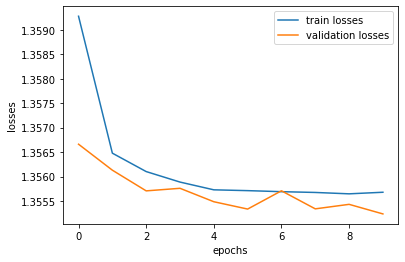

In [47]:
# Plotting in graph for small dataset
plt.plot(epoch_losses, label='train losses')
plt.plot(epoch_val_losses, label='validation losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()

In [ ]:
# Plotting in graph for LARGE dataset
plt.plot(epoch_losses, label='train losses')
plt.plot(epoch_val_losses, label='validation losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()

In [30]:
# Run this cell
# Check if word in vocabulary
unique_unknown_words = set()
def get_word_embedding(word):
    if word in w2v_model.wv:
        return w2v_model.wv[word]
    else:
        #print('out of vocabulary word')
        unique_unknown_words.add(word)
        return np.zeros(w2v_dim)
    
# print('zero array ', len(np.array(get_word_embedding('TEST'))))

In [ ]:
# 
# Testing
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
# epochs = 10
window_size = 2
#TEST_CSV = 'test1.csv'
TEST_CSV = 'test_original.csv'

test_df = pd.read_csv(TEST_CSV)

# 80% of total data in dataset is used for training and rest 20% will be used for testing
# from sklearn.model_selection import train_test_split
# train_X, test_X = train_test_split (train_df, test_size=0.2 )

questions_cols = ['lang1', 'lang2']
dataset = test_df

epoch_test_losses = list()

unique_total_words = set()


#keeping vocab size same as embedding dim
# model_param = ModelParam(101, 101, 200, 200, 200)
# model = crossLingualModel(model_param)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
# Testing
with torch.no_grad():
    
    intermediate_test_losses = list()
    for index, row in dataset.iterrows():
        #if (index % 10) == 0:
        print('test dataset index', index)
        #calculate paragraph vector for entire row
        sent_vector = get_mean_vector(text_to_word_list(row))
        #print(sent_vector)

        #keeping vocab size same as embedding dim
#             model_param = ModelParam(101, 101, 200, 200, 200, sent_vector)
#             model = crossLingualModel(model_param)
#             optimizer = optim.Adam(model.parameters(), lr=0.0001)

        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []
            for word_lang1 in context_words_lang1:
                unique_total_words.add(word_lang1)
                #ADD CHECK For out of vocabulary word
                lang1_array = np.array(get_word_embedding(word_lang1))

                #For normalizing array
#                     norm = np.linalg.norm(lang1_array)
#                     lang1_array = lang1_array/norm

                context_words_lang1_array.append(lang1_array)

            for word_lang2 in context_words_lang2:
                unique_total_words.add(word_lang2)
                #ADD CHECK For out of vocabulary word
                lang2_array = np.array(get_word_embedding(word_lang2))

                #For normalizing array
#                     norm = np.linalg.norm(lang2_array)
#                     lang2_array = lang2_array/norm

                context_words_lang2_array.append(lang2_array)

            prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)



            #embedding for target word in lang1
            #ADD CHECK For out of vocabulary word
            target1 = get_word_embedding(center_word_lang1)
            
            unique_total_words.add(center_word_lang1)
            

            # For normalizing
#                 norm1 = np.linalg.norm(target1)
#                 target1 = target1/norm1

            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)

            target1 = get_normalized_tensor(target1)

            # Normalize prediction1
#             normPrediction1 = transforms.Normalize(prediction1, prediction1)
#             #x = torch.randn(3, 224, 224)
#             prediction1 = normPrediction1(prediction1)


            prediction1 = get_normalized_tensor(prediction1)
            #print(prediction1)

#             if(epoch == 0):
#                 print(prediction1)
#                 print(prediction2)
                #print(target1)
                #print(np.sum(target1))

            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)

            #embedding for target word in lang2
            #ADD CHECK For out of vocabulary word
            target2 = get_word_embedding(center_word_lang2)
            
            unique_total_words.add(center_word_lang2)

            # For normalizing
#                 norm2 = np.linalg.norm(target2)
#                 target2 = target2/norm2

            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)

            target2 = get_normalized_tensor(target2)


            prediction2 = get_normalized_tensor(prediction2)

            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)

            summed_loss = loss_lang1 + loss_lang2  


            intermediate_test_losses.append(summed_loss.item())

            ## Assuming below lines not needed for test. need to confirm
            #model.zero_grad()
            #summed_loss.backward()
            #optimizer.step()

    print('intermediate_test_losses')
    print(intermediate_test_losses)

    epoch_test_losses.append(np.mean(intermediate_test_losses))
    

print('epoch_test_losses ',epoch_test_losses)
print('unique_total_words = ',len(unique_total_words))
print('unique_unknown_words = ',len(unique_unknown_words))



In [17]:
# PLEASE CHECK THIS CELL CAREFULLY
# Run this cell
# Testing for ROC curve with sent vector change
# This is the main cell for preparing center words and cotext words and iterates over entire dataset
# epochs = 10
window_size = 2
#TEST_CSV = 'test1.csv'
#TEST_CSV = 'test_original.csv'
TEST_CSV = 'test_all_original.csv'

test_df = pd.read_csv(TEST_CSV)

questions_cols = ['lang1', 'lang2']
dataset = test_df

epoch_test_losses = list()

unique_total_words = set()

threshold = 0.8
actual_zero_below_threshold = 0
found_zero_below_threshold = 0
actual_one_below_threshold = 0
actual_one_above_threshold = 0
found_one_above_threshold = 0
actual_zero_above_threshold = 0

y_pred = list()
y_true = list()

if_to_print_output = 0

# Testing
with torch.no_grad():
    
    intermediate_test_losses = list()
    for index, row in dataset.iterrows():
        #if (index % 10) == 0:
        #print('test dataset index', index)
        #calculate paragraph vector for entire row
        sent_vector = get_mean_vector(text_to_word_list(row))
        #print(sent_vector)
        
        sent_vector_x86 = get_mean_vector(text_to_word_list(row['lang1']))
        sent_vector_x86 = get_normalized_array_from_array_using_tensor_formula(sent_vector_x86)
        sent_vector_arm = get_mean_vector(text_to_word_list(row['lang2']))
        sent_vector_arm = get_normalized_array_from_array_using_tensor_formula(sent_vector_arm)
        #print('sent_vector_x86 ',sent_vector_x86)
        #print('sent_vector_arm ',sent_vector_arm)
#         cos_sim = np.dot(sent_vector_x86, sent_vector_arm)/(np.linalg.norm(sent_vector_x86)*np.linalg.norm(sent_vector_arm))
#         print('cos_sim ', cos_sim)
        
        result = 1 - spatial.distance.cosine(sent_vector_x86, sent_vector_arm)
        # Calculates the distance as defined by the MaLSTM model
#         result = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), \
#                         output_shape=lambda x: (x[0][0], 1))([sent_vector_x86, sent_vector_arm])

#         result = cityblock(sent_vector_x86, sent_vector_arm)
        
        

        if(result < threshold):
            y_pred.append(0)
            found_zero_below_threshold += 1
            if(row['if_similar'] == 0):
                actual_zero_below_threshold += 1
            else:
                actual_one_below_threshold += 1
        else:
            y_pred.append(1)
            found_one_above_threshold += 1
            if(row['if_similar'] == 1):
                actual_one_above_threshold += 1
            else:
                actual_zero_above_threshold += 1
        y_true.append(row['if_similar'])


        for context_words_lang1, context_words_lang2, center_word_lang1, center_word_lang2 in get_windows(text_to_word_list(row['lang1']), text_to_word_list(row['lang2']), window_size):
            context_words_lang1_array = []
            context_words_lang2_array = []
            for word_lang1 in context_words_lang1:
                unique_total_words.add(word_lang1)
                #ADD CHECK For out of vocabulary word
                lang1_array = np.array(get_word_embedding(word_lang1))

                context_words_lang1_array.append(lang1_array)

            for word_lang2 in context_words_lang2:
                unique_total_words.add(word_lang2)
                #ADD CHECK For out of vocabulary word
                lang2_array = np.array(get_word_embedding(word_lang2))

                context_words_lang2_array.append(lang2_array)

            prediction1, prediction2 = model(np.array(context_words_lang1_array), np.array(context_words_lang2_array), sent_vector)



            #embedding for target word in lang1
            #ADD CHECK For out of vocabulary word
            target1 = get_word_embedding(center_word_lang1)
            
            unique_total_words.add(center_word_lang1)

            target1 = torch.from_numpy(target1)
            target1 = torch.autograd.Variable(target1)
            target1 = target1.reshape(1,-1)

            target1 = get_normalized_tensor(target1)


            prediction1 = get_normalized_tensor(prediction1)


            loss_lang1 = nn.BCEWithLogitsLoss()(prediction1, target1)
            
            if(if_to_print_output<2):
                print('output ',prediction1)
                print('ground truth ',target1)
                print('loss x86', loss_lang1)
            
            #embedding for target word in lang2
            #ADD CHECK For out of vocabulary word
            target2 = get_word_embedding(center_word_lang2)
            
            unique_total_words.add(center_word_lang2)


            target2 = torch.from_numpy(target2)
            target2 = torch.autograd.Variable(target2)
            target2 = target2.reshape(1,-1)

            target2 = get_normalized_tensor(target2)


            prediction2 = get_normalized_tensor(prediction2)

            loss_lang2 = nn.BCEWithLogitsLoss()(prediction2, target2)
            
            if(if_to_print_output<2):
                print('output ',prediction2)
                print('ground truth ',target2)
                print('loss arm', loss_lang1)
                if_to_print_output += 1

            summed_loss = loss_lang1 + loss_lang2  


            intermediate_test_losses.append(summed_loss.item())


    epoch_test_losses.append(np.mean(intermediate_test_losses))
    

print('epoch_test_losses ',epoch_test_losses)
#print('unique_total_words = ',len(unique_total_words))
#print('unique_unknown_words = ',len(unique_unknown_words))

# print('with manhattan_distance')
print('with normalization, threshold ',threshold)
print('actual_zero_below_threshold ',actual_zero_below_threshold)
print('found_zero_below_threshold ',found_zero_below_threshold)
print('actual_one_below_threshold ',actual_one_below_threshold)
print('actual_one_above_threshold ',actual_one_above_threshold)
print('found_one_above_threshold ',found_one_above_threshold)
print('actual_zero_above_threshold ',actual_zero_above_threshold)



/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


output  tensor([[6.8440e-01, 4.4021e-02, 1.9737e-01, 8.2299e-02, 7.6318e-01, 9.8808e-02,
         3.0216e-03, 4.1444e-02, 5.3627e-02, 1.9861e-01, 3.5944e-01, 2.6297e-01,
         1.1134e-01, 9.6503e-02, 1.6601e-01, 1.6606e-01, 1.5104e-01, 2.6335e-01,
         2.5068e-01, 7.9103e-02, 9.5673e-01, 7.2874e-01, 2.4573e-01, 3.0512e-01,
         8.3010e-01, 6.0079e-03, 1.4325e-02, 3.0978e-02, 6.8462e-01, 4.1286e-01,
         2.1328e-02, 2.0172e-01, 2.1426e-02, 9.9420e-01, 1.9171e-01, 2.2902e-02,
         1.5727e-01, 6.9884e-01, 3.1535e-01, 1.9871e-01, 2.7940e-02, 1.7599e-02,
         4.3735e-02, 2.9893e-01, 3.8005e-01, 3.0119e-01, 4.0379e-02, 3.4043e-01,
         5.1567e-01, 3.5169e-01, 7.9269e-02, 4.9033e-01, 5.4237e-01, 3.9473e-01,
         2.1534e-02, 6.8075e-03, 6.5596e-01, 6.9981e-02, 9.0846e-02, 3.4336e-01,
         4.9533e-02, 8.2195e-01, 1.8630e-01, 1.1219e-01, 6.0581e-02, 2.3383e-02,
         5.3251e-01, 3.5870e-02, 7.1543e-01, 8.1446e-01, 6.4794e-01, 2.2682e-01,
         1.8775e-02,

/home/user/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


epoch_test_losses  [1.3553053496443233]
with normalization, threshold  0.8
actual_zero_below_threshold  699
found_zero_below_threshold  1563
actual_one_below_threshold  864
actual_one_above_threshold  9441
found_one_above_threshold  17382
actual_zero_above_threshold  7941


In [ ]:
# PLEASE CHECK THIS CELL CAREFULLY
# Actual TESTING CODE
# Run this cell
# Testing for ROC curve with sent vector change WITH UPDATED SENT CALCULATION

import math

# model = torch.load("saved_model.pth")
# model.eval()

window_size = 2
#TEST_CSV = 'test1.csv'
#TEST_CSV = 'test_original.csv'
TEST_CSV = 'test_all_original.csv'
# TEST_CSV = 'test_all_original_short.csv'
# TEST_CSV = 'test_all_original_short_1.csv'


test_df = cudf.read_csv(TEST_CSV)


questions_cols = ['lang1', 'lang2']
dataset = test_df

epoch_test_losses = list()

unique_total_words = set()


# threshold = -.003
threshold = -.4

actual_zero_below_threshold = 0
found_zero_below_threshold = 0
actual_one_below_threshold = 0
actual_one_above_threshold = 0
found_one_above_threshold = 0
actual_zero_above_threshold = 0

y_pred = list()
y_true = list()

if_to_print_output = 0

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

# Testing
with torch.no_grad():
    
    intermediate_test_losses = list()
    for row in dataset.to_pandas().itertuples():
#     for index, row in dataset.iterrows():
        #if (index % 10) == 0:
        #print('test dataset index', index)
        #calculate paragraph vector for entire row
        
        sent_vector_x86 = row.lang1 #get_mean_vector(text_to_word_list())
        sent_vector_arm = row.lang2 #get_mean_vector(text_to_word_list())
        
        prediction1, prediction2 = model(sent_vector_x86, sent_vector_arm, '')
#         prediction1 = get_normalized_tensor(prediction1).detach().numpy()
#         prediction2 = get_normalized_tensor(prediction2).detach().numpy()
        
        prediction1 = prediction1.detach().cpu().numpy()
        prediction2 = prediction2.detach().cpu().numpy()
        
#         print('prediction1 for test ',prediction1)
#         print('prediction2 for test ',prediction2)
        
        #print('sent_vector_x86 ',sent_vector_x86)
        #print('sent_vector_arm ',sent_vector_arm)
#         cos_sim = np.dot(sent_vector_x86, sent_vector_arm)/(np.linalg.norm(sent_vector_x86)*np.linalg.norm(sent_vector_arm))
#         print('cos_sim ', cos_sim)
        
#         result = 1 - spatial.distance.cosine(prediction1, prediction2)
#         if(result < threshold):
#             y_pred.append(0)
#             found_zero_below_threshold += 1
#             if(row.if_similar == 0):
#                 actual_zero_below_threshold += 1
#             else:
#                 actual_one_below_threshold += 1
#         else:
#             y_pred.append(1)
#             found_one_above_threshold += 1
#             if(row.if_similar == 1):
#                 actual_one_above_threshold += 1
#             else:
#                 actual_zero_above_threshold += 1
#         y_true.append(row.if_similar)
        # Calculates the distance as defined by the MaLSTM model
#         result = merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), \
#                         output_shape=lambda x: (x[0][0], 1))([sent_vector_x86, sent_vector_arm])

#         result = cityblock(sent_vector_x86, sent_vector_arm)
        
        
        #print('if_similar ',row['if_similar'])
#         print('result ',result)
        #print('type = ',type(row['if_similar']))
    
        
        
        sim = 1 - spatial.distance.cosine(np.asarray(prediction1), np.asarray(prediction2))
#         print('sim ',sim)
        if math.isnan(sim):
            print('nan')
        elif math.isinf(sim):
            print('inf')
        else:
            y_pred.append(sim)
            y_true.append(row.if_similar)
        
#         f = open("sim_output.txt", "a")
# #         f.write(str(x1))
#         f.write(str(sim))
#         f.close()
        


now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)


print('with normalization, threshold ',threshold)
print('actual_zero_below_threshold ',actual_zero_below_threshold)
print('found_zero_below_threshold ',found_zero_below_threshold)
print('actual_one_below_threshold ',actual_one_below_threshold)
print('actual_one_above_threshold ',actual_one_above_threshold)
print('found_one_above_threshold ',found_one_above_threshold)
print('actual_zero_above_threshold ',actual_zero_above_threshold)



Start Time = 20:23:28


/home/iftakhar/miniconda3/envs/rapids-0.16/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: divide by zero encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


inf
inf
inf


/home/iftakhar/miniconda3/envs/rapids-0.16/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


nan
inf
nan
nan


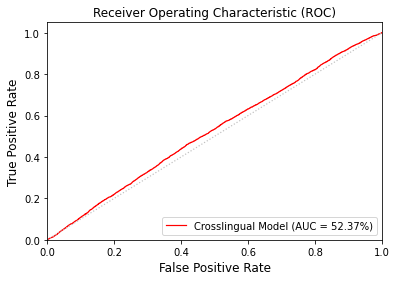

In [51]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)*100

plt.figure()
plt.plot(fpr, tpr, color='red', linewidth = 1.2, label='Crosslingual Model (AUC = %0.2f%%)' % roc_auc)

plt.plot([0, 1], [0, 1], color = 'silver', linestyle = ':', linewidth = 1.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()